In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse, sys, numpy as np, scipy as sc, warnings, os
draft_fd = 'modules/'
sys.path.append(draft_fd)
import flatsky, misc, exp_specs, ilc, foregrounds as fg

In [14]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'

# Get instrumental noise curves for S4

dict_keys([(27, 27), (27, 39), (27, 93), (27, 145), (27, 225), (27, 278), (39, 27), (39, 39), (39, 93), (39, 145), (39, 225), (39, 278), (93, 27), (93, 39), (93, 93), (93, 145), (93, 225), (93, 278), (145, 27), (145, 39), (145, 93), (145, 145), (145, 225), (145, 278), (225, 27), (225, 39), (225, 93), (225, 145), (225, 225), (225, 278), (278, 27), (278, 39), (278, 93), (278, 145), (278, 225), (278, 278)])


/Users/sraghunathan/Research/SPTpol/analysis/git/DRAFT/modules/misc.py:218: RuntimeWarning: divide by zero encountered in true_divide
  nl = np.copy(nl) * (1. + (elknee * 1./el)**alphaknee )
/Users/sraghunathan/Research/SPTpol/analysis/git/DRAFT/modules/misc.py:229: RuntimeWarning: divide by zero encountered in true_divide
  final_nl = rho * delta_T_radians * (elknee * 1./el)**(alphaknee/2.) * delta_T2_radians * (elknee2 * 1./el)**(alphaknee2/2.)


<Figure size 900x600 with 0 Axes>

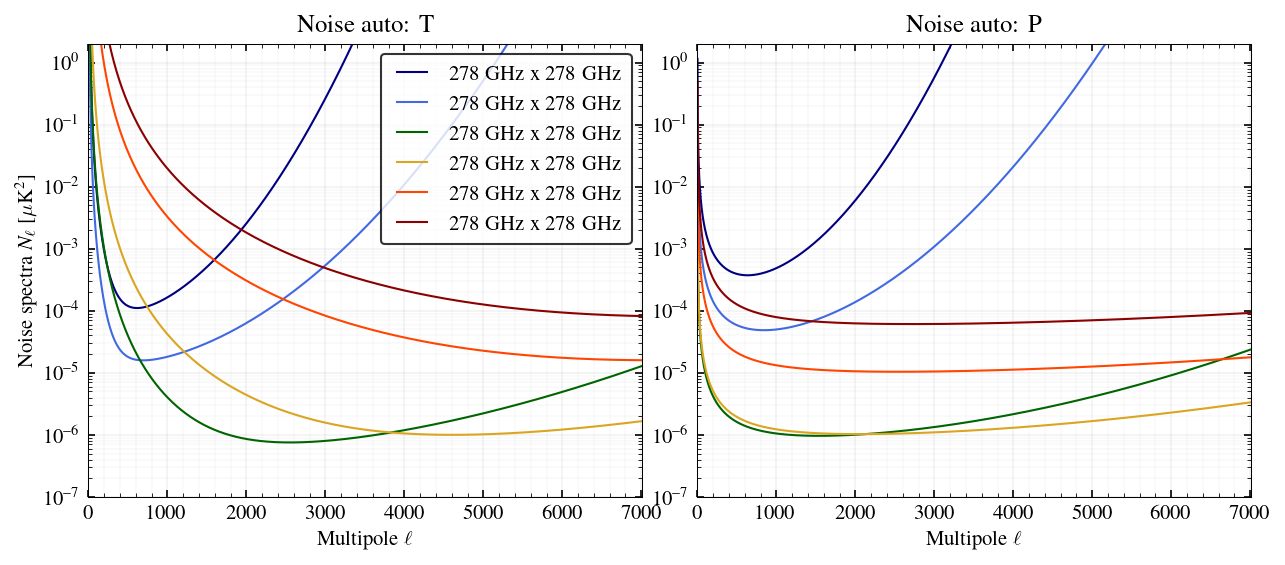

<Figure size 900x600 with 0 Axes>

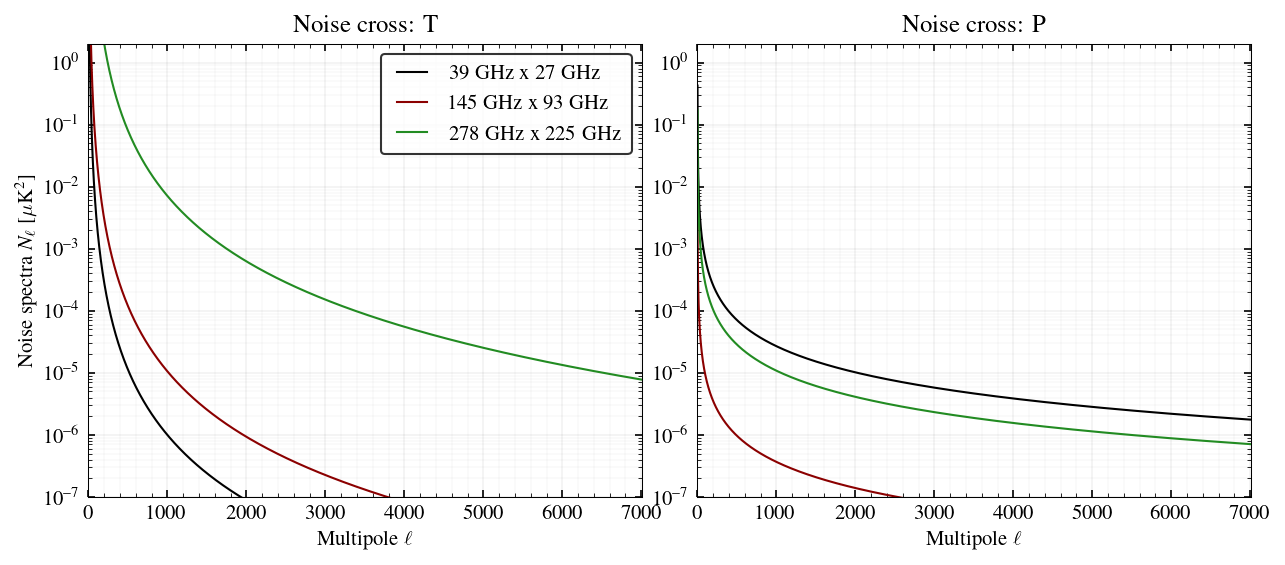

In [27]:
expname = 's4wide_202310xx_pbdr_config' #This is the S4-Wide configuration based on this spreadsheet 
#(https://docs.google.com/spreadsheets/d/10fL76XTzhgP_B_GKsEW4nqNTkRgvp2dh4zYh6Y-G2AE/edit#gid=0)

specs_dict, corr_noise_bands, rho, corr_noise, Nred_dic = exp_specs.get_exp_specs(expname)

########################################
########################################
#What do these corresond to?
#specs_dict - contains the noise and beam specs for the desired experiment
#keys --> bands
#print(specs_dict[145]) --> [1.4, 2.0, 3917.0, 3.5, 2.96, 700, 1.4]
#beam_in_arcmins, noise_in_T_uK_arcmin, el_knee_T, alpha_knee_T, noise_in_P_uK_arcmin, el_knee_P, alpha_knee_P

#corr_noise_bands - Atmospheric noise is correlated between bands for S4 for adjacent bands. 
#This dictionary gives information about that.

#rho - correlation coefficient for atmospheric noise between bands

#corr_noise = 1 (0) --> Indicites correalted noise is included (not included)

#Nred_dic --> Ignore this for S4. Only valid for SO-like config.
########################################
########################################

#get beam deconvolved noise nls
lmax = 7000
el = np.arange( lmax )
freqarr = list( specs_dict.keys() )
nl_dict = {}
nl_dict['T'] = {}
nl_dict['P'] = {}
for freq1 in freqarr:
    beam_1, noise_T_1, el_knee_T_1, alpha_knee_T_1, noise_P_1, el_knee_P_1, alpha_knee_P_1 = specs_dict[freq1]
    for freq2 in freqarr:
        beam_2, noise_T_2, el_knee_T_2, alpha_knee_T_2, noise_P_2, el_knee_P_2, alpha_knee_P_2 = specs_dict[freq2]

        if freq1 == freq2:
            nl_T = misc.get_nl(noise_T_1, el, beam_1, elknee = el_knee_T_1, alphaknee = alpha_knee_T_1)
            nl_P = misc.get_nl(noise_P_1, el, beam_1, elknee = el_knee_P_1, alphaknee = alpha_knee_P_1)
        else:
            if freq2 in corr_noise_bands[freq1]:
                nl_T = misc.get_nl(noise_T_1, el, beam_1, elknee = el_knee_T_1, alphaknee = alpha_knee_T_1, beamval2 = beam_2, noiseval2 = noise_T_2, elknee2 = el_knee_T_2, alphaknee2 = alpha_knee_T_2, rho = rho)
                nl_P = misc.get_nl(noise_P_1, el, beam_1, elknee = el_knee_P_1, alphaknee = alpha_knee_P_1, beamval2 = beam_2, noiseval2 = noise_P_2, elknee2 = el_knee_P_2, alphaknee2 = alpha_knee_P_2, rho = rho)
            else:
                nl_T = np.zeros( len(el) )
                nl_P = np.zeros( len(el) )

        nl_dict['T'][(freq1, freq2)] = nl_T
        nl_dict['P'][(freq1, freq2)] = nl_P


print(nl_dict['T'].keys())

#plot noise auto-correlation curves
color_dict = {27: 'navy', 39: 'royalblue', 93: 'darkgreen', 145: 'goldenrod', 225: 'orangered', 278: 'darkred'}
clf()
figure(figsize = (10., 4.) )
subplots_adjust(wspace = 0.1)
for TPcntr, TP in enumerate( ['T', 'P'] ):
    ax = subplot(1, 2, TPcntr+1, yscale = 'log')
    for freq in freqarr:
        curr_nl = nl_dict[TP][(freq, freq)]
        plot(el, curr_nl, color = color_dict[freq], label = r'%s GHz x %s GHz' %(freq1, freq2))

    xlabel(r'Multipole $\ell$')
    if TPcntr == 0:
        ylabel(r'Noise spectra $N_{\ell}$ [$\mu$K$^{2}$]')
        legend(loc = 1)
    xlim(0, lmax+10)
    ylim(1e-7, 2.)
    grid(True, axis = 'both', which = 'major', lw = 0.2, alpha = 0.2)
    grid(True, axis = 'both', which = 'minor', lw = 0.1, alpha = 0.2)
    title(r'Noise auto: %s' %(TP))
show()
    

#plot noise cross-correlation curves
color_dict = {27: 'navy', 39: 'royalblue', 93: 'darkgreen', 145: 'goldenrod', 225: 'orangered', 278: 'darkred'}
clf()
figure(figsize = (10., 4.) )
subplots_adjust(wspace = 0.1)
for TPcntr, TP in enumerate( ['T', 'P'] ):
    ax = subplot(1, 2, TPcntr+1, yscale = 'log')
    for freq1 in freqarr:
        freq2 = corr_noise_bands[freq1][0]
        if freq1 == freq2: continue #ignore autos.
        if freq2>freq1: continue #already plotted
        curr_nl = nl_dict[TP][(freq1, freq2)]
        plot(el, curr_nl, label = r'%s GHz x %s GHz' %(freq1, freq2))

    xlabel(r'Multipole $\ell$')
    if TPcntr == 0:
        ylabel(r'Noise spectra $N_{\ell}$ [$\mu$K$^{2}$]')
        legend(loc = 1)
    xlim(0, lmax+10)
    ylim(1e-7, 2.)
    grid(True, axis = 'both', which = 'major', lw = 0.2, alpha = 0.2)
    grid(True, axis = 'both', which = 'minor', lw = 0.1, alpha = 0.2)
    title(r'Noise cross: %s' %(TP))
show()



# Now let us get the foreground noise curves

/Users/sraghunathan/Research/SPTpol/analysis/git/DRAFT/modules/foregrounds.py:374: RuntimeWarning: invalid value encountered in true_divide
  cl_rg = dl_rg / dl_fac
/Users/sraghunathan/Research/SPTpol/analysis/git/DRAFT/modules/foregrounds.py:233: RuntimeWarning: invalid value encountered in true_divide
  cl_dg_po = dl_dg_po / dl_fac
/Users/sraghunathan/Research/SPTpol/analysis/git/DRAFT/modules/foregrounds.py:234: RuntimeWarning: invalid value encountered in true_divide
  cl_dg_clus = dl_dg_clus / dl_fac


dict_keys(['TT', 'PP']) dict_keys(['TT', 'PP'])


<Figure size 900x600 with 0 Axes>

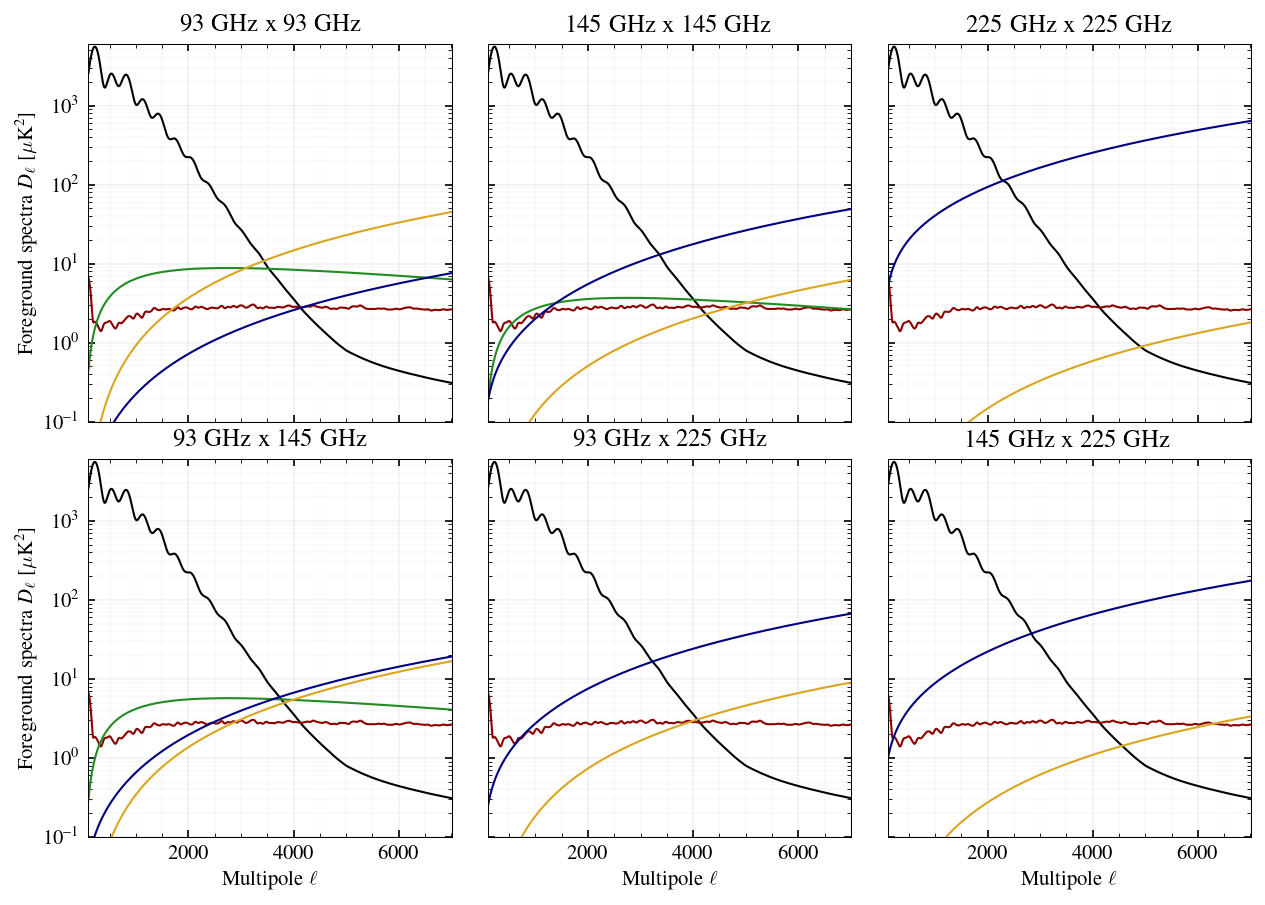

In [45]:
#let us define some variables

#params
paramfile = 'scripts/params.ini'

# read and store param dict
param_dict = misc.fn_get_param_dict(paramfile)

'''
#polarisation fractions assumptions
pol_frac_per_cent_radio = 0.03 #3 per cent pol fraction for radio galaxies
pol_frac_per_cent_dust = 0.02 #2 per cent pol fraction for dusty galaxies
pol_frac_per_cent_ksz = 0.0
pol_frac_per_cent_tsz = 0.0
'''

#galactic foreground - not included here but the tools has this feature.
include_gal = 0

cl_dict = {}
fg_cl_dict = {}
for which_spec in ['TT', 'PP']:
    if which_spec == 'TT':
        el, cl_dict[which_spec], fg_cl_dict[which_spec] = ilc.get_analytic_covariance(param_dict, freqarr, el = el,nl_dic = nl_dict['T'], include_gal = include_gal)#, bl_dic = bl_dic)
    else:
        el, cl_dict[which_spec], fg_cl_dict[which_spec] = ilc.get_analytic_covariance(param_dict, freqarr, el = el, nl_dic = nl_dict['P'], which_spec = which_spec, pol_frac_per_cent_dust = param_dict['pol_frac_per_cent_dust'], pol_frac_per_cent_radio = param_dict['pol_frac_per_cent_radio'], pol_frac_per_cent_tsz = param_dict['pol_frac_per_cent_tsz'], pol_frac_per_cent_ksz = param_dict['pol_frac_per_cent_ksz'], include_gal = include_gal)#, bl_dic = bl_dic)
print(cl_dict.keys(), fg_cl_dict.keys())

#plot foreground spectra for some bands
which_spec_to_plot = 'TT'
fg_comp_dict_to_plot = {'cmb': r'CMB', 'ksz': r'kSZ', 'tsz': r'tSZ', 'radio': r'Radio', 'cib': r'CIB'}
fg_color_dict = {'cmb': 'gray', 'ksz': 'purple', 'tsz': 'navy', 'radio': 'royalblue', 'cib': 'orangered'}
freq_combs_to_plot = [[93, 93], [145, 145], [225, 225], [93, 145], [93, 225], [145, 225]]
clf()
tr, tc = 2, 3 #2 rows, 3 columns for 3 bands
figure(figsize = (10., 7.) )
subplots_adjust(wspace = 0.1, hspace = 0.1)
sbpl = 1
for freq1, freq2 in freq_combs_to_plot:
    ax = subplot(tr, tc, sbpl, yscale = 'log')
    for fg_comp in fg_comp_dict_to_plot:
        curr_fg_cl = fg_cl_dict[which_spec][fg_comp][(freq1, freq2)]

        dl_fac = el * (el+1)/2/np.pi
        plot(el, dl_fac * curr_fg_cl, label = r'%s' %(fg_comp_dict_to_plot[fg_comp]))

    if (sbpl-1) % tc == 0:
        ylabel(r'Foreground spectra $D_{\ell}$ [$\mu$K$^{2}$]')
    else:
        setp(ax.get_yticklabels(which = 'both'), visible=False)
    if sbpl>tc:
        xlabel(r'Multipole $\ell$')
    else:
        setp(ax.get_xticklabels(which = 'both'), visible=False)
    if sbpl == 0:
        legend(loc = 1)

    xlim(100, lmax+10)
    ylim(0.1, 6e3)
    grid(True, axis = 'both', which = 'major', lw = 0.2, alpha = 0.2)
    grid(True, axis = 'both', which = 'minor', lw = 0.1, alpha = 0.2)
    title(r'%s GHz x %s GHz' %(freq1, freq2))
    sbpl += 1
show()
